# Researching a Pairs Trading Strategy

By Delaney Granizo-Mackenzie

Minor updates for jupyter and Python 3 compatibiliy by Ken Gleason

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

Pairs trading is a nice example of a strategy based on mathematical analysis. The principle is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. We'll start by constructing an artificial example.

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 8 )

## Explaining the Concept: We start by generating two fake securities.
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

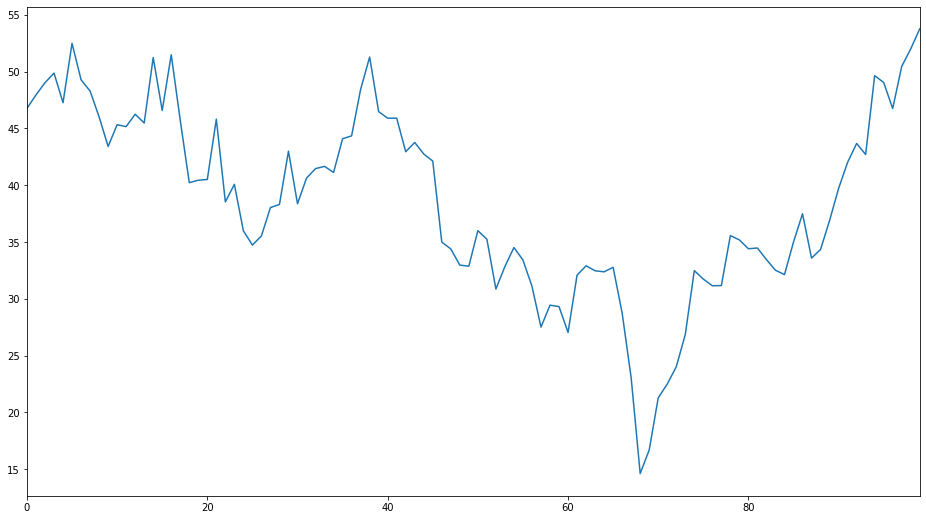

In [5]:
X_returns = np.random.normal(0, 3, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot(figsize = ( 16, 9 ))
plt.show()

Now we generate Y. Remember that Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly. We model this by taking X, shifting it up and adding some random noise drawn from a normal distribution.

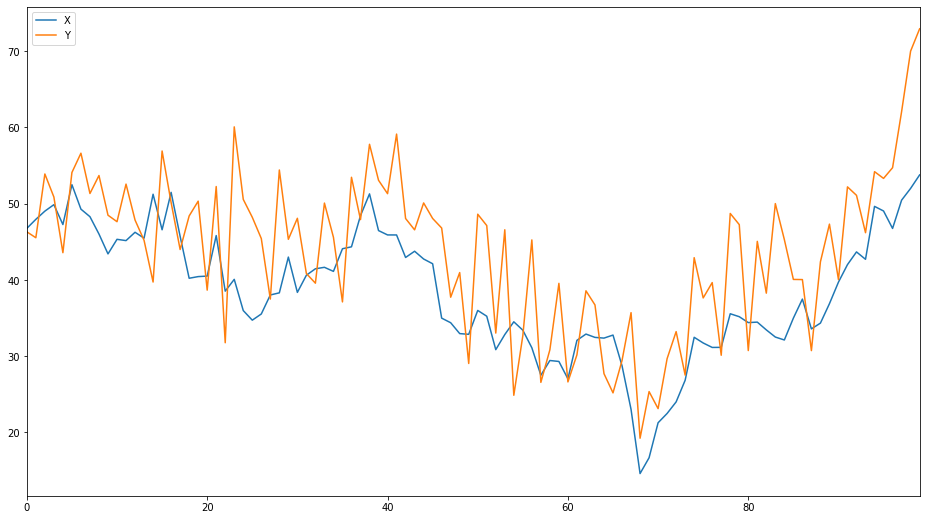

In [6]:
some_noise = np.random.normal(0, 6, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot(figsize=(16,9))
plt.show()

## Def: Cointegration

We've constructed an example of two cointegrated series. Cointegration is a "different" form of correlation (very loosely speaking). The spread between two cointegrated timeseries will vary around a mean. The expected value of the spread over time must converge to the mean for pairs trading work work. Another way to think about this is that cointegrated timeseries might not necessarily follow a similar path to a same destination, but they both end up at this destination.

We'll plot the spread between the two now so we can see how this looks.

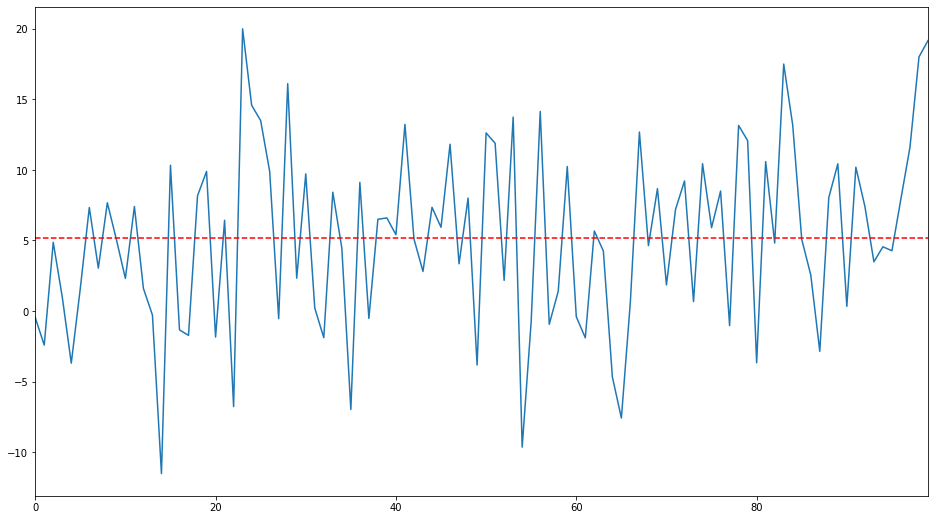

In [8]:
(Y-X).plot(figsize=(16,9)) # Plot the spread
plt.axhline((Y-X).mean(), color='red', linestyle='--') # Add the mean
plt.show()

## Testing for Cointegration

That's an intuitive definition, but how do we test for this statistically? There is a convenient test that lives in `statsmodels.tsa.stattools`. We should see a very low p-value, as we've artifically created two series that are as cointegrated as physically possible.

In [9]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread btwn the 2 timeseries is stationary
# around its mean
score, pvalue, crit_vals = coint(X,Y)
print( pvalue )

0.0016380007716119615


### Correlation vs. Cointegration

Correlation and cointegration, while theoretically similar, are not the same. To demonstrate this, we'll show examples of series that are correlated, but not cointegrated, and vice versa. To start let's check the correlation of the series we just generated.

In [10]:
X.corr(Y)

0.778983016562119

That's very high, as we would expect. But how would two series that are correlated but not cointegrated look? 

### Correlation Without Cointegration

A simple example is two series that just diverge.

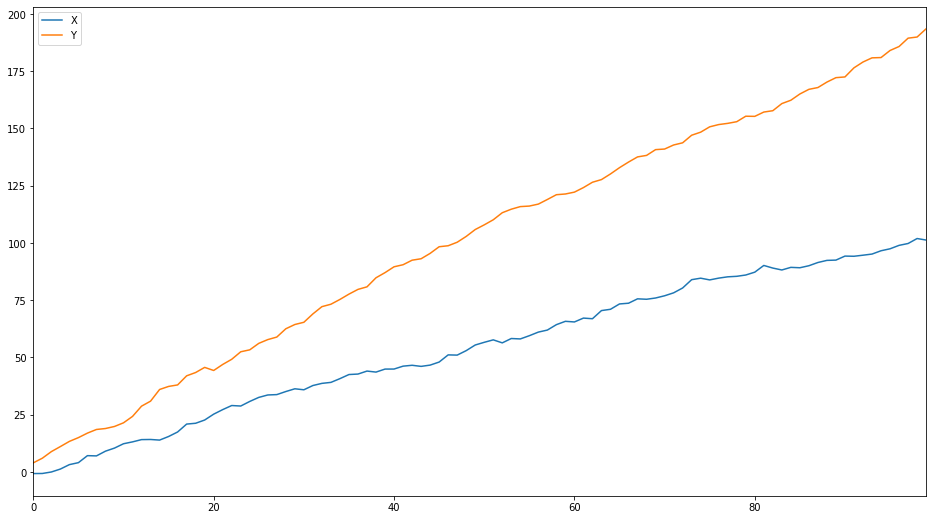

In [11]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(16,9))

In [12]:
print( 'Correlation: ' + str(X_diverging.corr(Y_diverging)) )
score, pvalue, crit_val = coint(X_diverging,Y_diverging)
print( 'Cointegration test p-value: ' + str(pvalue) )
print(score)
print(crit_val)

Correlation: 0.9970395686931033
Cointegration test p-value: 0.24132690193233924
-2.5889027082657763
[-4.01048603 -3.39854434 -3.08756793]


### Cointegration Without Correlation

A simple example of this case is a normally distributed series and a square wave.

In [13]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

In [14]:
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

(0, 40)

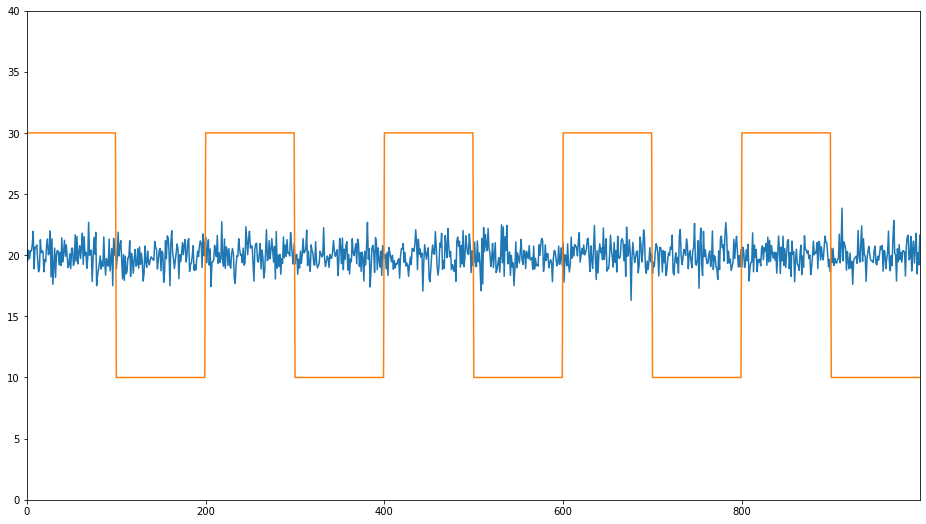

In [15]:
Y2.plot(figsize=(16,9))
Y3.plot()
plt.ylim([0, 40])

In [16]:
# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)) )
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue) )
print( score )

Correlation: 0.029110303615995065
Cointegration test p-value: 0.0
-32.5264968541782


Sure enough, the correlation is incredibly low, but the p-value shows perfect cointegration.

## The Trick: Where it all comes together
Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across X and Y. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the difference of the two reverting to the mean. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

## Finding real securities that behave like this
The best way to do this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you'll fall prey to multiple comparison bias.

Here's a method I wrote to look through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05.

In [17]:
def find_cointegrated_pairs(securities_panel):
    n = len(securities_panel.minor_axis)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities_panel.keys
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = securities_panel.minor_xs(securities_panel.minor_axis[i])
            S2 = securities_panel.minor_xs(securities_panel.minor_axis[j])
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((securities_panel.minor_axis[i], securities_panel.minor_axis[j]))
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Alternative Energy Securities
I'm looking through a set of solar company stocks to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security for the year of 2014.

get_pricing() is a Quantopian method that pulls in stock data, and loads it into a Python Pandas DataPanel object.  Available fields are 'price', 'open_price', 'high', 'low', 'volume'.  But for this example we will just use 'price' which is the daily closing price of the stock.

In [ ]:
symbol_list = ['ABGB', 'ASTI', 'CSUN', 'DQ', 'FSLR','SPY']
securities_panel = get_pricing(symbol_list, fields=['price']
                               , start_date='2014-01-01', end_date='2015-01-01')
securities_panel.minor_axis = map(lambda x: x.symbol, securities_panel.minor_axis)

Example of how to get all the prices of all the stocks loaded using get_pricing() above in one pandas dataframe object

In [15]:
securities_panel.loc['price'].head(5)

,ABGB,ASTI,CSUN,DQ,FSLR,SPY
2014-01-02 00:00:00+00:00,14.4198,7.409,7.0400,38.00,57.43,182.95
2014-01-03 00:00:00+00:00,14.7546,7.250,7.0775,39.50,56.74,182.80
2014-01-06 00:00:00+00:00,15.3300,7.121,7.0000,40.05,51.26,182.40
2014-01-07 00:00:00+00:00,15.6300,7.299,6.9300,41.93,52.48,183.44
2014-01-08 00:00:00+00:00,15.3100,7.101,7.1600,42.49,51.68,183.53


Example of how to get just the prices of a single stock that was loaded using get_pricing() above

In [16]:
securities_panel.minor_xs('SPY').head(5)

,price
2014-01-02 00:00:00+00:00,182.95
2014-01-03 00:00:00+00:00,182.80
2014-01-06 00:00:00+00:00,182.40
2014-01-07 00:00:00+00:00,183.44
2014-01-08 00:00:00+00:00,183.53


Now we'll run our method on the list and see if any pairs are cointegrated.

[(u'ABGB', u'FSLR')]


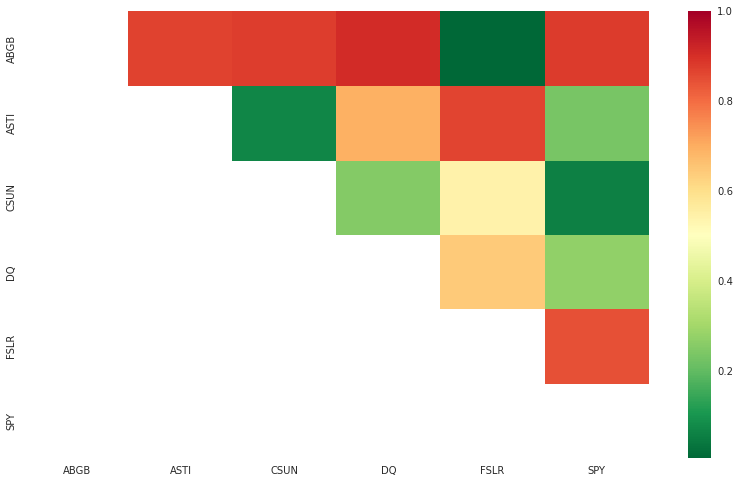

In [17]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
# (Just showing a '1' for everything in lower diagonal)

scores, pvalues, pairs = find_cointegrated_pairs(securities_panel)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.95)
                )
print pairs

Looks like 'ABGB' and 'FSLR' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

In [18]:
S1 = securities_panel.loc['price']['ABGB']
S2 = securities_panel.loc['price']['FSLR']

In [19]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.0060792512281637916

We'll plot the spread of the two series.

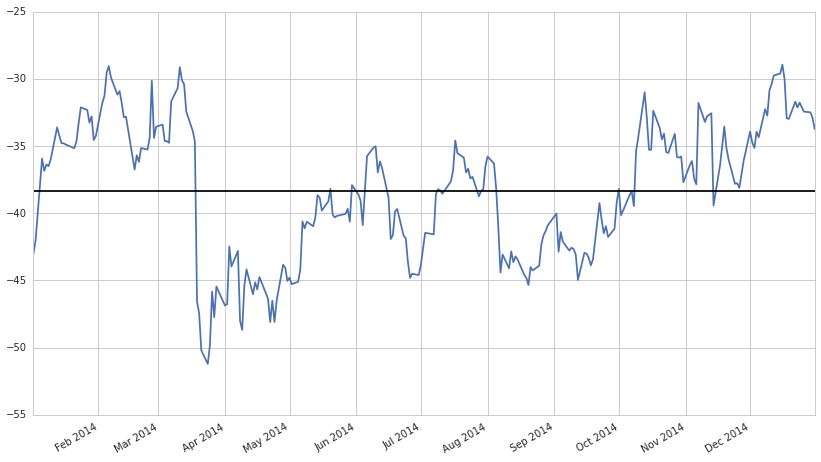

In [20]:
diff_series = S1 - S2
diff_series.plot()
plt.axhline(diff_series.mean(), color='black')

The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. This way we associate probabilities to the signals we see. If we see a z-score of 1, we know that approximately 84% of all spread values will be smaller.

In [21]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

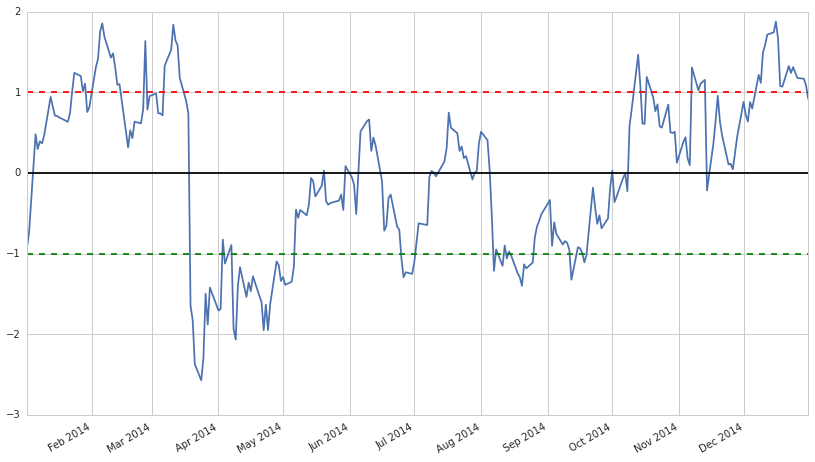

In [22]:
zscore(diff_series).plot()
plt.axhline(zscore(diff_series).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')


### Simple Strategy: 
* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero

Since we originally defined the "spread" as S1-S2, "Long" the spread would mean "Buy 1 share of S1, and Sell Short 1 share of S2" (and vice versa if you were going "Short" the spread)

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.  In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2.  Some additional resources on pair trading are listed at the end of this notebook

##Trading using constantly updating statistics

## Def: Moving Average
A moving average is just an average over the last $n$ datapoints for each given time. It will be undefined for the first $n$ datapoints in our series.

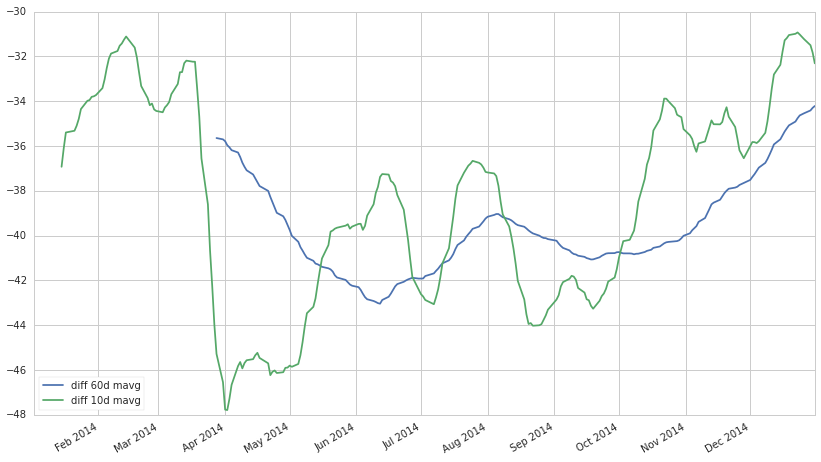

In [23]:
# Get the difference in prices between the 2 stocks
difference = S1 - S2
difference.name = 'diff'

# Get the 10 day moving average of the difference
diff_mavg10 = pd.rolling_mean(difference, window=10)
diff_mavg10.name = 'diff 10d mavg'

# Get the 60 day moving average
diff_mavg60 = pd.rolling_mean(difference, window=60)
diff_mavg60.name = 'diff 60d mavg'

pd.concat([diff_mavg60, diff_mavg10], axis=1).plot()
# pd.concat([diff_mavg60, diff_mavg10, difference], axis=1).plot()

We can use the moving averages to compute the z-score of the difference at each given time. This will tell us how extreme the difference is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

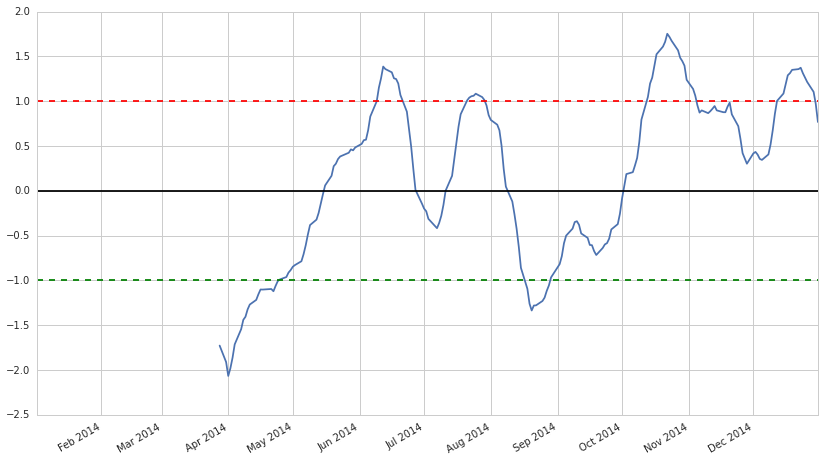

In [24]:
# Take a rolling 60 day standard deviation
std_60 = pd.rolling_std(difference, window=60)
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_10 = (diff_mavg10 - diff_mavg60)/std_60
zscore_60_10.name = 'z-score'
zscore_60_10.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the differences were all negative and that's kinda confusing.

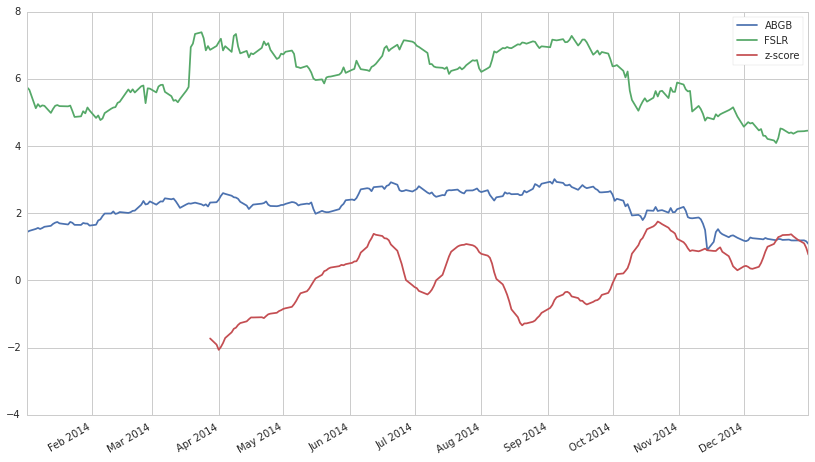

In [25]:
two_stocks = securities_panel.loc['price'][['ABGB', 'FSLR']]
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
pd.concat([two_stocks/10, zscore_60_10], axis=1).plot()

##This notebook contained some simple introductory approaches. In practice one should use more sophisticated statistics, some of which are listed here.

* Augmented-Dickey Fuller test 
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
* Kalman filters

(this is *not* an endorsement) But, a very good practical resource for learning more about pair trading is Dr. Ernie Chan's book:  Algorithmic Trading: Winning Strategies and Their Rationale
http://www.amazon.com/Algorithmic-Trading-Winning-Strategies-Rationale/dp/1118460146/